In [634]:
import wandb
import os
import pandas as pd
import time
%matplotlib inline
import importlib
from common import common
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
import eli5
from eli5.sklearn import explain_prediction_sklearn

In [635]:
wandb.login()

True

In [636]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project/work/common/common.py'>

In [697]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [698]:
# project name should correspond to dataset below
# project_name = "thyroid"
# project_name = "cirrhosis"
project_name = "heart"
# project_name = "hepatitis"

In [699]:
if project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "heart":
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()
else:
    %run datasets/hepatitis.ipynb
    all_df, main_labels, config = get_processed_hepatitis_df()

Normal class:  0    0
dtype: int64


In [700]:
# Should already be one hot encoded and label encoded
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS'].copy()
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,age,trestbps,chol,thalch,oldpeak,num,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True
0,63,145.0,233.0,150.0,2.3,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,67,160.0,286.0,108.0,1.5,2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,67,120.0,229.0,129.0,2.6,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,37,130.0,250.0,187.0,3.5,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,41,130.0,204.0,172.0,1.4,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [701]:
all_df.shape

(918, 19)

In [702]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(734, 18) (184, 18) (734,) (184,)


In [703]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [1 0 0 0 2 2 0 0 1 0 3 1 0 1 3 0 3 0 1 1 0 3 1 0 2 0 1 0 1 0 3 0 1 0 1 1 0
 1 1 0 0 0 0 2 2 0 1 1 0 3 2 0 0 0 0 0 0 1 0 3 2 1 3 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 1 0 3 0 0 1 1 1 0 1 0 0 0 0 1 0 3 0 0 0 1 0 1 1 2 2 0 1 0 0 0 0 1
 0 3 3 0 3 1 1 3 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 3 2 0 3 0 1 0 1 0 0 0
 0 0 2 0 1 2 0 1 3 0 2 1 0 0 0 3 0 0 0 0 1 2 0 1 0 1 1 0 0 0 0 0 1 1 2 0]
Total operation time: =  0.12131905555725098 seconds


Multiclass Classification Evaluation


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


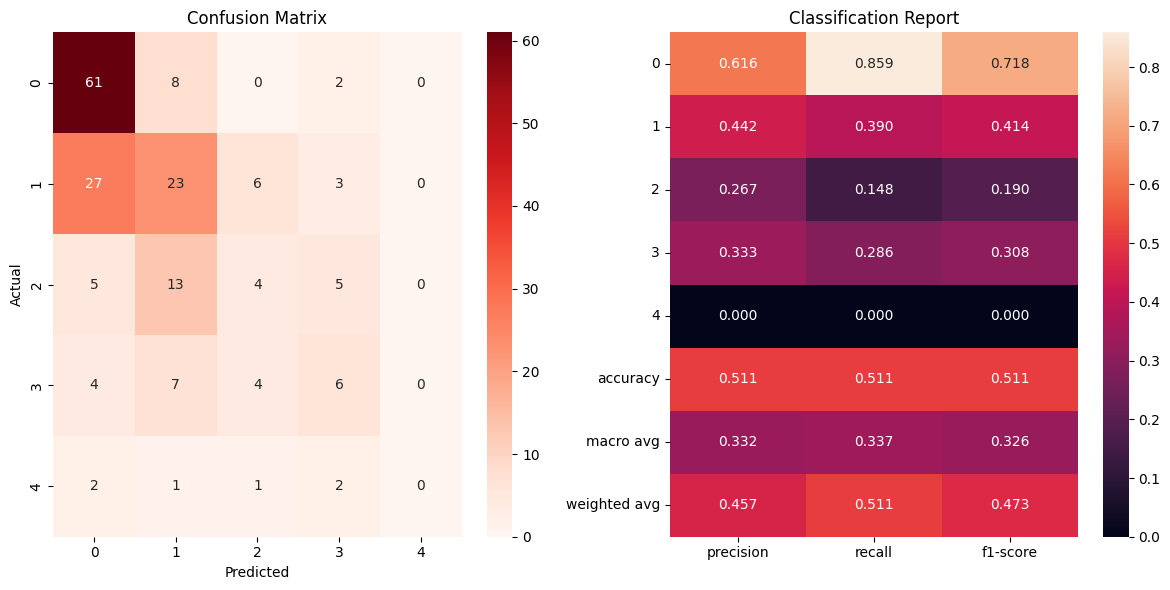

Accuracy: 0.5108695652173914


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.51087
f1-score_avg,0.47287
precision_avg,0.45676
recall_avg,0.51087


In [607]:
pn = "final-pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [667]:
# Extract decision rules and feature importance
rules = eli5.explain_weights(rf, feature_names=list(X_train_df.columns))
# display(rules)
print(eli5.format_as_text(rules))

Explained as: feature importances

Random forest feature importances; values are numbers 0 <= x <= 1;
all values sum to 1.

0.1529 ± 0.0526  age
0.1525 ± 0.0596  thalch
0.1285 ± 0.0452  chol
0.1199 ± 0.0423  trestbps
0.1187 ± 0.0424  oldpeak
0.0715 ± 0.0854  cp_asymptomatic
0.0364 ± 0.0680  exang_True
0.0277 ± 0.0628  exang_False
0.0249 ± 0.0204  restecg_normal
0.0242 ± 0.0235  fbs_True
0.0222 ± 0.0234  fbs_False
0.0216 ± 0.0201  restecg_lv hypertrophy
0.0211 ± 0.0389  cp_atypical angina
0.0203 ± 0.0152  restecg_st-t abnormality
0.0191 ± 0.0259  sex_Female
0.0167 ± 0.0230  sex_Male
0.0145 ± 0.0210  cp_non-anginal
0.0074 ± 0.0105  cp_typical angina


In [668]:
from sklearn.tree import export_text, plot_tree
# Here we use out-of-bag score or use Gini Importance as criteria
best_tree_index = max(range(len(rf.estimators_)),
                      key=lambda i: rf.estimators_[i].score(X_train_df, y_train_df))
best_tree = rf.estimators_[best_tree_index]

feature_names = X_train_df.columns
tree_rules = export_text(best_tree, feature_names=feature_names)
print("Best Tree's Decision Rules:")
print(tree_rules)
# plot_tree(best_tree, feature_names=feature_names)

In [686]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [704]:
print(all_df.shape)

if project_name == "thyroid":
    # Applying log transformation to reduce skewness
    all_df['log_TSH'] = np.log1p(all_df['TSH'])
    all_df['log_FTI'] = np.log1p(all_df['FTI'])
    all_df['log_TT4'] = np.log1p(all_df['TT4'])
    all_df['log_T3'] = np.log1p(all_df['T3'])
    all_df = all_df.drop(['TSH', 'FTI', 'TT4', 'T3'], axis=1)

elif project_name == "cirrhosis":
    all_df['Age_Bilirubin_interaction'] = all_df['Age'] * all_df['Bilirubin']
    all_df['Age_Copper_interaction'] = all_df['Age'] * all_df['Copper']
    all_df['Age_Prothrombin_interaction'] = all_df['Age'] * all_df['Prothrombin']
    all_df['Age_SGOT_interaction'] = all_df['Age'] * all_df['SGOT']
    all_df['Age_Platelets_interaction'] = all_df['Age'] * all_df['Platelets']
    all_df = all_df.drop(['Bilirubin', 'Copper', 'Prothrombin', 'SGOT', 'Platelets'], axis=1)
    
elif project_name == "heart":
    all_df['age_chol_interaction'] = all_df['age'] * all_df['chol']
    all_df['age_thalch_interaction'] = all_df['age'] * all_df['thalch']
    all_df['age_trestbps_interaction'] = all_df['age'] * all_df['trestbps']
    all_df['age_oldpeak_interaction'] = all_df['age'] * all_df['oldpeak']
    all_df = all_df.drop(['chol', 'thalch', 'trestbps', 'oldpeak'], axis=1)

else:
    all_df['Age_AST_interaction'] = all_df['Age'] * all_df['AST']
    all_df['Age_CHE_interaction'] = all_df['Age'] * all_df['CHE']
    all_df['Age_ALT_interaction'] = all_df['Age'] * all_df['ALT']
    all_df['Age_ALP_interaction'] = all_df['Age'] * all_df['ALP']
    all_df['Age_GGT_interaction'] = all_df['Age'] * all_df['GGT']
    all_df['Age_BIL_interaction'] = all_df['Age'] * all_df['BIL']
    all_df['Age_PROT_interaction'] = all_df['Age'] * all_df['PROT']
    all_df['Age_ALB_interaction'] = all_df['Age'] * all_df['ALB']
    all_df = all_df.drop(['Age', 'AST', 'CHE', 'ALT', 'ALP', 'GGT', 'BIL', 'PROT', 'ALB'], axis=1)

print(all_df.shape)

(918, 19)
(918, 19)


In [705]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(734, 18) (184, 18) (734,) (184,)


In [706]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [707]:
main_labels = all_df.columns
print(main_labels)

Index(['age', 'num', 'sex_Female', 'sex_Male', 'cp_asymptomatic',
       'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina',
       'fbs_False', 'fbs_True', 'restecg_lv hypertrophy', 'restecg_normal',
       'restecg_st-t abnormality', 'exang_False', 'exang_True',
       'age_chol_interaction', 'age_thalch_interaction',
       'age_trestbps_interaction', 'age_oldpeak_interaction'],
      dtype='object')


In [708]:
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS'].copy()

if project_name == "thyroid":
    for col in ['log_TSH', 'log_FTI', 'log_TT4', 'log_T3']:
        NUMERICAL_COLUMNS.append(col)
    for col in ['TSH', 'FTI', 'TT4', 'T3']:
        NUMERICAL_COLUMNS.remove(col)

elif project_name == "cirrhosis":
    for col in ['Age_Bilirubin_interaction', 'Age_Copper_interaction', 'Age_Prothrombin_interaction', 'Age_SGOT_interaction', 'Age_Platelets_interaction']:
        NUMERICAL_COLUMNS.append(col)
    for col in ['Bilirubin', 'Copper', 'Prothrombin', 'SGOT', 'Platelets']:
        NUMERICAL_COLUMNS.remove(col)
        
elif project_name == "heart":    
    for col in ['age_chol_interaction', 'age_thalch_interaction', 'age_trestbps_interaction',
                'age_oldpeak_interaction']:
        NUMERICAL_COLUMNS.append(col)
    for col in ['chol', 'thalch', 'trestbps', 'oldpeak']:
        NUMERICAL_COLUMNS.remove(col)

else:
    for col in ['Age_AST_interaction', 'Age_CHE_interaction', 'Age_ALT_interaction', 'Age_ALP_interaction',
                'Age_GGT_interaction', 'Age_BIL_interaction', 'Age_PROT_interaction', 'Age_ALB_interaction']:
        NUMERICAL_COLUMNS.append(col)
    for col in ['Age', 'AST', 'CHE', 'ALT', 'ALP', 'GGT', 'BIL', 'PROT', 'ALB']:
        NUMERICAL_COLUMNS.remove(col)

print(NUMERICAL_COLUMNS)

['age', 'age_chol_interaction', 'age_thalch_interaction', 'age_trestbps_interaction', 'age_oldpeak_interaction']


In [709]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)

In [710]:
seconds = time.time()

minor_type_counts = all_df[TARGET_COLUMN].value_counts()
minor_type_dict = minor_type_counts.to_dict()
print('minor_type_dict', minor_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target

    common.get_dataset_for_label(label, name, target_index, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

minor_type_dict {0: 411, 1: 263, 2: 109, 3: 107, 4: 28}
Slight Presence.csv created with 674 rows. (411 major and 263 minor rows)
Presence.csv created with 520 rows. (411 major and 109 minor rows)
Moderate Presence.csv created with 518 rows. (411 major and 107 minor rows)
High Presence.csv created with 439 rows. (411 major and 28 minor rows)
All datasets created successfully!
Total operation time: = 0.004397153854370117 seconds


csv_files ['High Presence.csv', 'Moderate Presence.csv', 'Slight Presence.csv', 'Presence.csv']
Index(['age', 'num', 'sex_Female', 'sex_Male', 'cp_asymptomatic',
       'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina',
       'fbs_False', 'fbs_True', 'restecg_lv hypertrophy', 'restecg_normal',
       'restecg_st-t abnormality', 'exang_False', 'exang_True',
       'age_chol_interaction', 'age_thalch_interaction',
       'age_trestbps_interaction', 'age_oldpeak_interaction'],
      dtype='object')
Processing CSV file: High Presence.csv
High Presence importance list:
High Presence 
                           importance
Features                            
age_oldpeak_interaction     0.334790
age_trestbps_interaction    0.137435
age                         0.105580
age_thalch_interaction      0.093278
age_chol_interaction        0.089264
cp_asymptomatic             0.056395
exang_True                  0.024539
exang_False                 0.022313
restecg_st-t abnormality    0.01

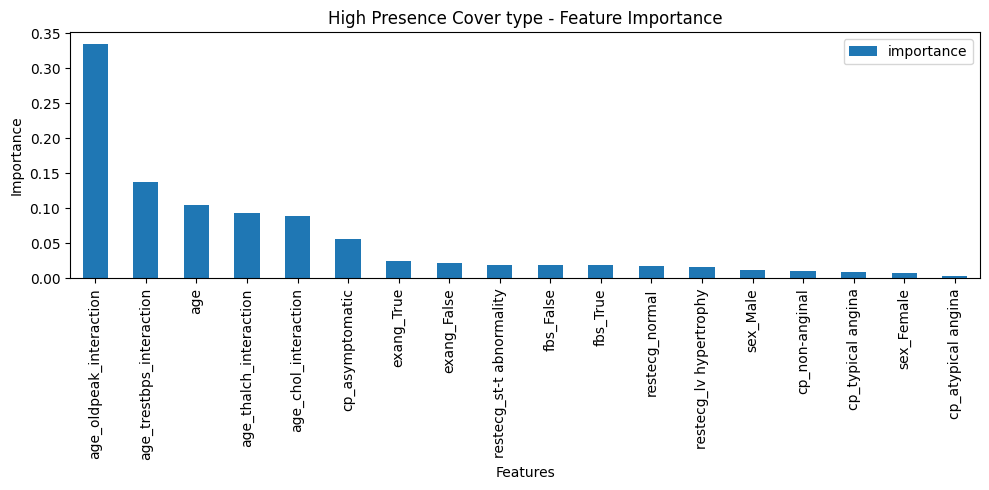

-----------------------------------------------------------------------------------------------




Processing CSV file: Moderate Presence.csv
Moderate Presence importance list:
Moderate Presence 
                           importance
Features                            
age_oldpeak_interaction     0.185181
age_thalch_interaction      0.115415
age_trestbps_interaction    0.110789
age_chol_interaction        0.100140
age                         0.099947
exang_True                  0.075629
cp_asymptomatic             0.075379
exang_False                 0.071998
cp_atypical angina          0.021575
sex_Male                    0.021260
sex_Female                  0.021079
fbs_True                    0.020974
fbs_False                   0.020864
cp_non-anginal              0.014013
restecg_st-t abnormality    0.013851
restecg_normal              0.013104
restecg_lv hypertrophy      0.011686
cp_typical angina           0.007116 



Moderate Presence=["age_oldpeak_interaction","age_thalch_i

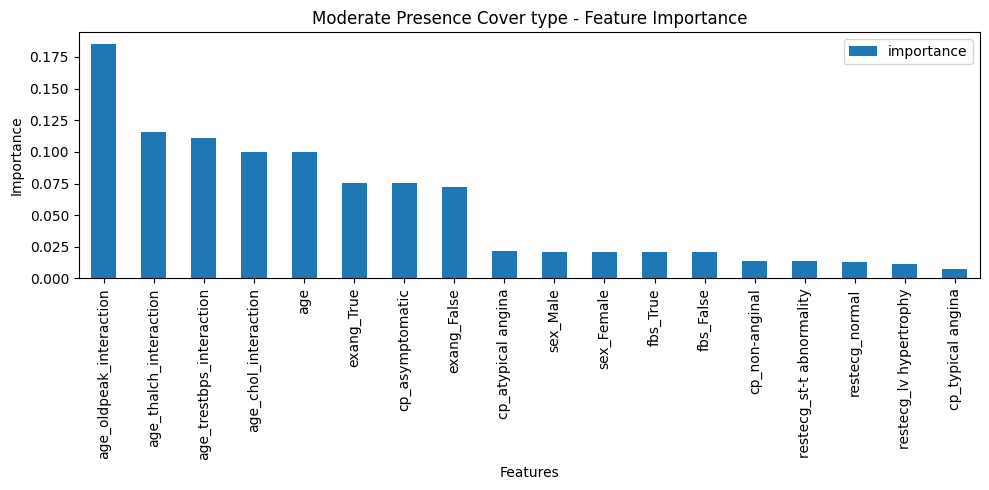

-----------------------------------------------------------------------------------------------




Processing CSV file: Slight Presence.csv
Slight Presence importance list:
Slight Presence 
                           importance
Features                            
age_oldpeak_interaction     0.136362
age_chol_interaction        0.117720
age_trestbps_interaction    0.117707
cp_asymptomatic             0.115203
age_thalch_interaction      0.114607
age                         0.091308
exang_True                  0.057983
exang_False                 0.049433
cp_atypical angina          0.037946
sex_Male                    0.023554
fbs_True                    0.021699
sex_Female                  0.021168
cp_non-anginal              0.020545
fbs_False                   0.018001
restecg_normal              0.017572
restecg_st-t abnormality    0.016654
restecg_lv hypertrophy      0.012291
cp_typical angina           0.010246 



Slight Presence=["age_oldpeak_interaction","age_chol_interaction

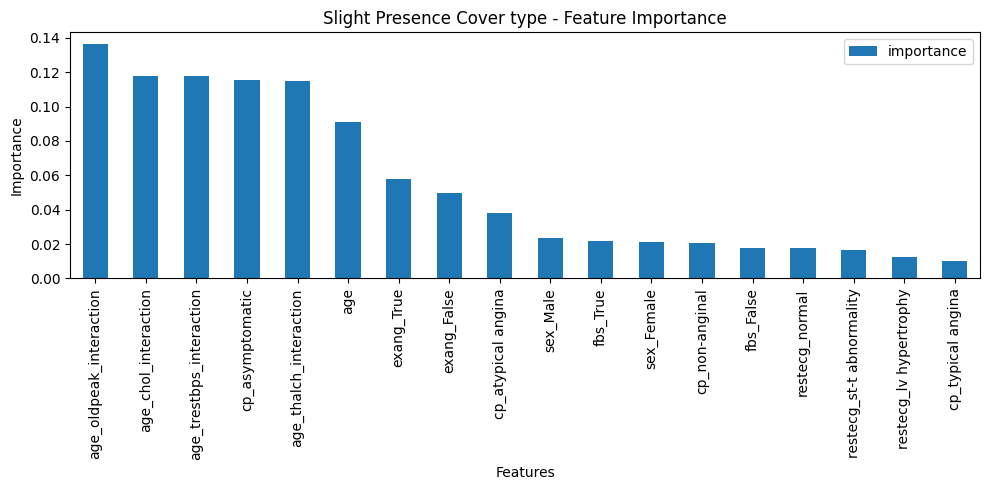

-----------------------------------------------------------------------------------------------




Processing CSV file: Presence.csv
Presence importance list:
Presence 
                           importance
Features                            
age_oldpeak_interaction     0.209671
age_thalch_interaction      0.118769
cp_asymptomatic             0.111831
age_chol_interaction        0.111689
age_trestbps_interaction    0.106282
age                         0.080674
exang_False                 0.039550
exang_True                  0.037923
fbs_False                   0.034134
fbs_True                    0.023704
cp_atypical angina          0.022940
sex_Male                    0.020182
restecg_st-t abnormality    0.018680
sex_Female                  0.018275
cp_non-anginal              0.014710
restecg_normal              0.012912
restecg_lv hypertrophy      0.010292
cp_typical angina           0.007784 



Presence=["age_oldpeak_interaction","age_thalch_interaction","cp_asymptomatic","age_c

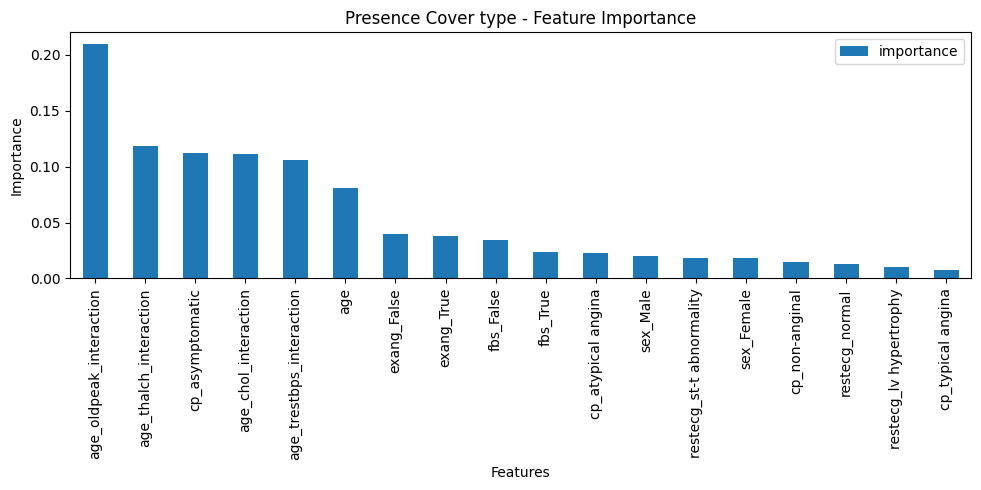

-----------------------------------------------------------------------------------------------




feature_importances: {'High Presence': ['age_oldpeak_interaction', 'age_trestbps_interaction', 'age', 'age_thalch_interaction', 'age_chol_interaction'], 'Moderate Presence': ['age_oldpeak_interaction', 'age_thalch_interaction', 'age_trestbps_interaction', 'age_chol_interaction', 'age'], 'Slight Presence': ['age_oldpeak_interaction', 'age_chol_interaction', 'age_trestbps_interaction', 'cp_asymptomatic', 'age_thalch_interaction'], 'Presence': ['age_oldpeak_interaction', 'age_thalch_interaction', 'cp_asymptomatic', 'age_chol_interaction', 'age_trestbps_interaction']}
Total operation time: = 1.3350532054901123 seconds


In [711]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}
modelname = "knn"

print(main_labels)
# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler,
        modelname=modelname)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [712]:
seconds = time.time()
CONF_THRESHOLD = 0.95

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    major_class_prob = knn_prediction[:, 1]
    minor_class_prob = knn_prediction[:, 0]
    
    return (minor_class_prob, major_class_prob)
    
def process_instance(i, test_instance_df):
    if test_predictions[i] == NORMAL_TARGET:
        max_prob = CONF_THRESHOLD
        final_class_1 = NORMAL_TARGET
        final_class_2 = final_class_1

        for key, knn in KNNs.items():
            sub_minor_class_prob, sub_major_class_prob = predict_knn(key, test_instance_df)
            if sub_minor_class_prob > sub_major_class_prob and sub_minor_class_prob > max_prob:
                max_prob = sub_minor_class_prob
                final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'NORMAL improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'NORMAL deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)

    else:
        predicted_label = TARGET_DICT[test_predictions[i]]
        minor_class_prob, major_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = minor_class_prob if minor_class_prob > major_class_prob else major_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if minor_class_prob > major_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if major_class_prob > 1.0 - CONF_THRESHOLD and major_class_prob < CONF_THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_minor_class_prob, sub_major_class_prob = predict_knn(key, test_instance_df)
                    if sub_minor_class_prob > sub_major_class_prob and sub_minor_class_prob > max_prob:
                        max_prob = sub_minor_class_prob
                        final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, major_class_prob, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, major_class_prob, max_prob)

    return i, final_class_2

# Run all test data instances in parallel and retain order
knn_predictions = [None] * len(X_test_scaled_df) 

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_instance, idx, X_test_scaled_df.iloc[idx].to_frame().T): idx for idx in range(len(X_test_scaled_df))}

    for future in as_completed(futures):
        idx, prediction = future.result()
        knn_predictions[idx] = prediction 

print("Total operation time: = ", time.time() - seconds, "seconds")

final_class1 1 final_class2 3 actual final_class13  0improvefinal_class1   final_class20 [0.19433471]1 final_class1 final_class2 [1.]
 actualfinal_class1final_class1  1  final_class1030 final_class1actual      1final_class2final_class230 final_class2    improvefinal_class21 12  final_class2 1 [0.58590618]2  actualimprove   actual1  actual[1.]1 actual[0.78226955] 
  2  NORMAL improve2 [1.]1 actualimprove  
NORMAL improve  final_class1improve[0.25312922] 1 [1.]   
[0.17611282][1.]NORMAL improve[1.]
  [1.]
[1.]
3
 final_class2 1 actual 1 improve [0.36530562] [1.]
final_class1 1final_class1  final_class21  2final_class2  3actual  2actual  3improve final_class1 improve final_class1  [0.19477141]3 [0.46453665]
0[1.]  final_class1[1.] final_class2final_class1
  final_class2 1 102    final_class2actualfinal_class2actual    3142  actual  improveNORMAL improve actual  3 [1.] [0.31152061]4
improve final_class1  [1.]NORMAL improve 
[0.16656217] 0 [1.] [1.]
final_class2
final_class1  03 final_class

KNN Evaluation (overall)


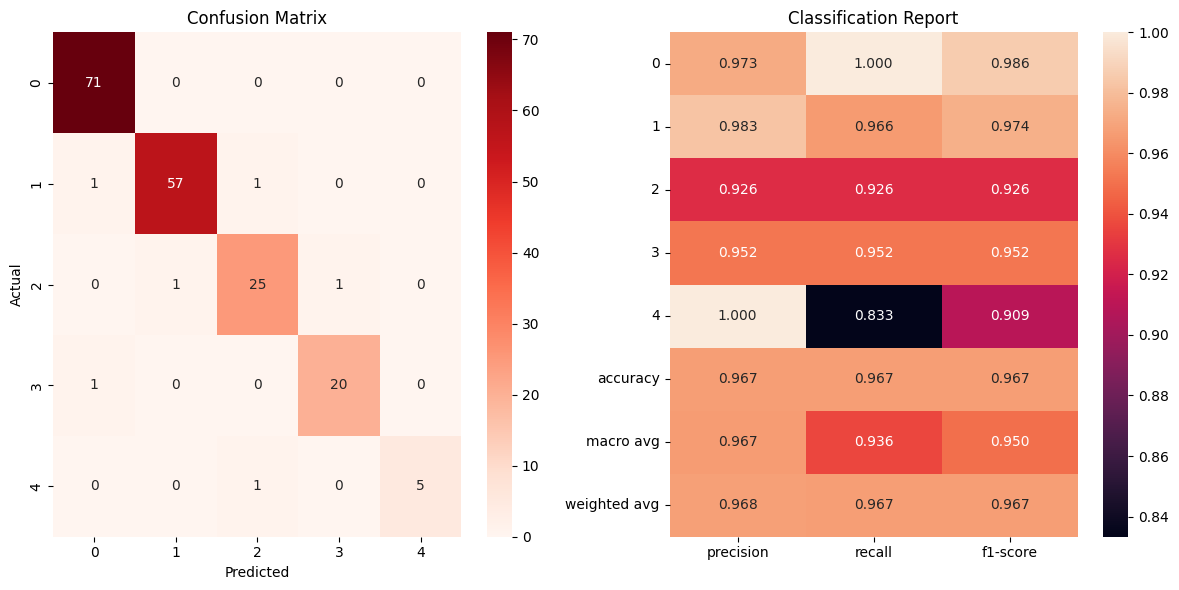

Accuracy: 0.967391304347826


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.96739
f1-score_avg,0.96715
precision_avg,0.9676
recall_avg,0.96739


In [713]:
# Evaluate KNN on all test data
pn = "final-pipeline-" + project_name
wandb.init(project=pn, name="final")

final_knn_predictions_df = pd.DataFrame(knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()